In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

all_data = pd.read_csv('../all_data.csv', index_col=0)
PM25 = pd.read_csv('../PM25.csv', index_col=0)
model_data = all_data = pd.concat([all_data, PM25], axis=1)
model_data = model_data.rename(columns={model_data.columns[-1]: "PM2.5"})
model_data = model_data.dropna(subset=["PM2.5"])
model_data

X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)

In [7]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def objective(trial):
    X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
    y = model_data["PM2.5"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)
    

    hidden_layer_sizes = [trial.suggest_int('n_units1', 2, 150),
                          trial.suggest_int('n_units2', 2, 25)]
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    alpha = trial.suggest_float('alpha', 1e-3, 0.5,log=True)

    model = MLPRegressor(max_iter=10000,hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=alpha, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    

    return r2

study = optuna.create_study(direction='maximize')
improvement_threshold = 0.001
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 400 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Najlepsze parametry:", best_params)
print("Najlepszy R^2 Score:", best_r2)


[I 2023-11-07 22:01:37,843] A new study created in memory with name: no-name-8937d069-e995-4e7a-819f-fb6883a355df
[I 2023-11-07 22:01:42,580] Trial 0 finished with value: 0.9092317718135894 and parameters: {'n_units1': 75, 'n_units2': 9, 'activation': 'tanh', 'alpha': 0.09247052186629517}. Best is trial 0 with value: 0.9092317718135894.
[I 2023-11-07 22:01:44,400] Trial 1 finished with value: 0.8861472403711852 and parameters: {'n_units1': 49, 'n_units2': 15, 'activation': 'relu', 'alpha': 0.07089858462062557}. Best is trial 0 with value: 0.9092317718135894.
[I 2023-11-07 22:01:49,143] Trial 2 finished with value: 0.9166130972215556 and parameters: {'n_units1': 52, 'n_units2': 10, 'activation': 'tanh', 'alpha': 0.02161482481779877}. Best is trial 2 with value: 0.9166130972215556.
[I 2023-11-07 22:01:50,504] Trial 3 finished with value: 0.8295318586086048 and parameters: {'n_units1': 32, 'n_units2': 24, 'activation': 'identity', 'alpha': 0.01069784054956819}. Best is trial 2 with value:

Najlepsze parametry: {'n_units1': 130, 'n_units2': 7, 'activation': 'tanh', 'alpha': 0.019678805492729032}
Najlepszy R^2 Score: 0.9519006617908236


Średni błąd kwadratowy (MSE): 30.301329544130294
Procentowa zgodność: 95.19%


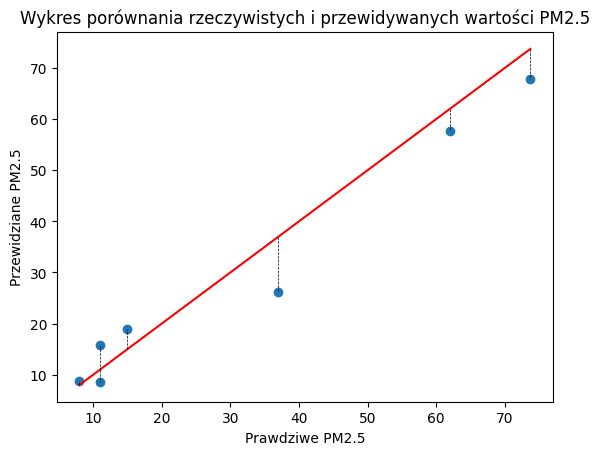

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
0,11.00,15.742255,-4.742255
1,10.98,8.662209,2.317791
2,73.73,67.910583,5.819417
3,15.00,18.953613,-3.953613
4,8.00,8.746675,-0.746675
5,37.00,26.227923,10.772077
6,62.02,57.758976,4.261024


In [8]:
from sklearn.neural_network import MLPRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

{'n_units1': 86, 'n_units2': 7, 'activation': 'tanh', 'alpha': 0.03535368780463305}
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data["PM2.5"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)


model = MLPRegressor(max_iter=10000,hidden_layer_sizes=[130,7],activation='tanh',alpha=0.019678805492729032,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results
